In [6]:
from __future__ import division #always returns approximations from divisions
import numpy as np
import matplotlib.pyplot as plt
import ephem #for astronomy calculations, converting coordinate systems
import pandas as pd
from astroquery.gaia import Gaia

In [7]:
v_df = pd.read_csv('voy1_ephemeris_3mon.txt', skiprows = 35, skipfooter=302-251, engine='python') # df of info about voyager's position
s_df = pd.DataFrame(columns = ['source_id', 'g_abs', 'bp_rp', 'parallax']) # df of info about stars

print(v_df)

                   date na1 na2         ra       dec  Unnamed: 5
0     1977-Sep-06 00:00           65.45370  25.53700         NaN
1     1977-Dec-06 00:00           50.31389  20.96930         NaN
2     1978-Mar-06 00:00           69.10376  23.07894         NaN
3     1978-Jun-06 00:00          101.37895  23.70404         NaN
4     1978-Sep-06 00:00          127.85607  19.55239         NaN
..                  ...  ..  ..        ...       ...         ...
209   2029-Dec-06 00:00          259.16828  12.05672         NaN
210   2030-Mar-06 00:00          259.53401  12.19674         NaN
211   2030-Jun-06 00:00          259.26702  12.41173         NaN
212   2030-Sep-06 00:00          258.94077  12.27292         NaN
213   2030-Dec-06 00:00          259.23706  12.06216         NaN

[214 rows x 6 columns]


In [8]:
for i in range(len(v_df.index)):
    #query to cone search around given voyager's position
    query = """SELECT source_id, phot_g_mean_mag+5*log10(ABS(parallax)/1000)+5 AS g_abs, bp_rp, parallax, abs(1000/parallax) AS dist
    FROM gaiaedr3.gaia_source
    WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', """ + str(v_df['ra'][i]) + """,""" + str(v_df['dec'][i]) + """, 0.035603))
    """
    
    results = Gaia.launch_job_async(query).get_results() #results from gaia query
    results = results.to_pandas().dropna() #convert to pandas

    s_df = pd.concat([s_df, results], ignore_index = True)
    
s_df = s_df.drop_duplicates(subset=['source_id']) #only keep unique rows
print(s_df)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [12]:
s_df.to_csv('voyager1_stars_3mon.csv') #save stars
s_df1 = s_df[s_df['dist'] <= 100]
s_df1.to_csv('voyager1_stars_within100.csv')
print(s_df1)

       Unnamed: 0            source_id      g_abs     bp_rp   parallax  \
10083       10083  4540596097701725952  15.154395  1.413088  15.388211   
10192       10192  4541335695367625344   7.384612  1.682703  16.399704   
10336       10336  4540584071792701952   7.857426  1.694512  15.289236   
11307       11314  4540604451415976704  11.750153  3.441657  14.374295   

            dist  
10083  64.984811  
10192  60.976711  
10336  65.405490  
11307  69.568627  


<ipython-input-10-0a0bd80e25f1>:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
  color_map.set_bad(color='white') #set color as white for masked values


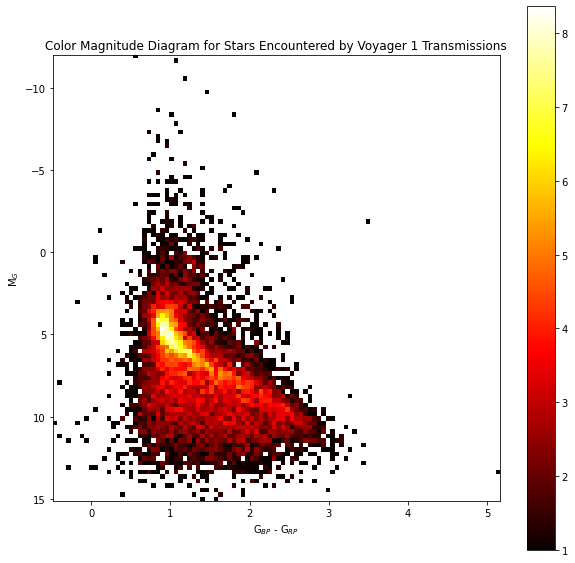

In [10]:
#build hr diagram
s_df = pd.read_csv('voyager1_stars_3mon.csv') #get csv

histogram, xedges, yedges = np.histogram2d(
   s_df['bp_rp'], s_df['g_abs'], bins=100)

histogram = np.ma.masked_where(histogram == 0.0, histogram) #map zero values
histogram = histogram.T #list bins with common y range

color_map = plt.cm.get_cmap("hot") #set colors for diagram
color_map.set_bad(color='white') #set color as white for masked values

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] #bounding box in data

#plotting

plt.figure(figsize=(10, 10))

#plt.savefig('gaia_100_parsecs.png')
plt.imshow(np.sqrt(histogram), origin='lower', cmap=color_map,
    extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2])
    )

plt.colorbar()
plt.title("Color Magnitude Diagram for Stars Encountered by Voyager 1 Transmissions")
plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')
plt.gca().invert_yaxis()
plt.savefig('voyager1_stars_hr.png')

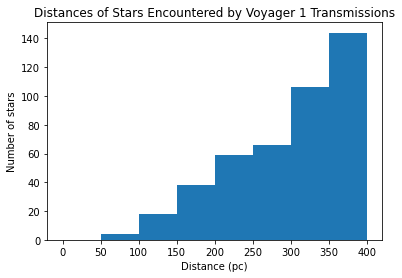

In [11]:
s_df = pd.read_csv('voyager1_stars_3mon.csv') #get csv

plt.hist(abs(1000/s_df['parallax']), bins = [0, 50, 100, 150, 200, 250, 300, 350, 400]) #plot parallax (mas) converted to distance (pc) in histogram

plt.title("Distances of Stars Encountered by Voyager 1 Transmissions") #labels
plt.xlabel("Distance (pc)")
plt.ylabel("Number of stars")

plt.savefig("voyager1_dist_hist_3mon.png")
plt.show()